## Import Libraries

In [6]:
import time 
import numpy as np
import pandas as pd
import time
import datetime
from datetime import datetime
import statistics
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 5000)


## Load dataset (play by play data for every mlb game in 2020)
I web scraped this data from the espn.com play by play commentaries for each baseball match in 2020 (regular and postseason). Each row is equal to one pitch. The rows include the inning, the count (before and after the pitch), the pitch velocity, the pitch result, the type of pitch thrown, and the number of pitches thrown by the pitcher in the game so far. <br><br>
I generated the number of pitches thrown column myself, and it took a few hours to create that row, so I have saved the data after creating that row.

In [7]:
# df = pd.read_csv('mlb1').iloc[:,1:].drop_duplicates().reset_index().iloc[:,1:]
# df['count_'] = df.apply(lambda x: str(x['pitch_count_balls'])+'-'+str(x['pitch_count_strikes']),axis=1)
# df = df.reset_index()

In [8]:
# def pitches_in_inning(pitcher,match,index):
#     result = df.iloc[:index+1,:].loc[(df['match_id']==match) & (df['pitcher']==pitcher)].shape[0]
#     return result

# df['pitches'] = df.apply(lambda x: pitches_in_inning(x['pitcher'],x['match_id'],x['index']),axis=1)

In [9]:
# df.to_csv('saved_mlb_analysis')
df = pd.read_csv('saved_mlb_analysis').iloc[:,1:]
df.head(10)

,index,pitcher,pitching_team,batter,batting_team,at_bat_id,match_id,period,pitch_result_balls,pitch_result_strikes,pitch_velocity,pitch_result,pitch_type,pitch_count_balls,pitch_count_strikes,count_,pitches
0,0,Max Scherzer,WSH,Aaron Hicks,NYY,4012256740001,401225674,1,1,0,95.0,ball,Four-seam FB,0,0,0-0,1
1,1,Max Scherzer,WSH,Aaron Hicks,NYY,4012256740001,401225674,1,2,0,96.0,ball,Four-seam FB,1,0,1-0,2
2,2,Max Scherzer,WSH,Aaron Hicks,NYY,4012256740001,401225674,1,2,1,96.0,strike looking,Four-seam FB,2,0,2-0,3
3,3,Max Scherzer,WSH,Aaron Hicks,NYY,4012256740001,401225674,1,2,2,79.0,strike looking,Curve,2,1,2-1,4
4,4,Max Scherzer,WSH,Aaron Hicks,NYY,4012256740001,401225674,1,2,2,96.0,ground out,Four-seam FB,2,2,2-2,5
5,5,Max Scherzer,WSH,Aaron Judge,NYY,4012256740002,401225674,1,1,0,96.0,ball,Four-seam FB,0,0,0-0,6
6,6,Max Scherzer,WSH,Aaron Judge,NYY,4012256740002,401225674,1,1,1,86.0,strike looking,Slider,1,0,1-0,7
7,7,Max Scherzer,WSH,Aaron Judge,NYY,4012256740002,401225674,1,1,1,96.0,single,Four-seam FB,1,1,1-1,8
8,8,Max Scherzer,WSH,Gleyber Torres,NYY,4012256740003,401225674,1,0,1,87.0,strike looking,Slider,0,0,0-0,9
9,9,Max Scherzer,WSH,Gleyber Torres,NYY,4012256740003,401225674,1,1,1,95.0,ball,Four-seam FB,0,1,0-1,10


### Clean the data and format for analysis
I have created my own metric called expected bases. Expected bases calculates each players return (or output) from facing a pitcher. <br><br>
For example, if a player scores a single, a walk or any other play that results in him getting to first base, this equals one expected base. If a player scores a double, this equals two and so on. If a player is struck out or caught, or cannot make a play, this will be zero. <br><br>
I sum up a players total expected bases and divide it by the number of trips to plate, and this gives me and expected bases for each hitter, and expected bases given up for each pitcher.
<br><br>
This is similar to OPS, but combines slugging and OBP a bit more accurutely rather than adding them together. 
<br><br>
Expected bases will be how I measure the success of various teams, players and strategies

In [10]:

df1 = df.drop_duplicates(subset=['at_bat_id'],keep='last')

not_out = ['ground rule double',
 'wild pitch; runner reached',
 'ball',
 'batter reached on error (batter to first)',
 'catchers interference (batter to first/error)',
 'bunt single',
 'strikeout batter safe, passed ball',
 'batters fielders choice (all runners safe)',
 'double',
 'hit by pitch',
 'home run',
 'single',
 'triple']
df1['expected_bases'] = df1['pitch_result'].apply(lambda x: 1 if x.lower() in not_out else 0
                   )+df1['pitch_result'].apply(lambda x: 1 if 'double' in x.lower() else 0
                   )+df1['pitch_result'].apply(lambda x: 1 if 'triple' in x.lower() else 0
                 )*2+df1['pitch_result'].apply(lambda x: 1 if 'home run' in x.lower() else 0)*3
output = df1[['at_bat_id','expected_bases']]
df1 = df1[['pitcher','pitching_team', 'batter', 'batting_team','pitch_result']]

df = pd.merge(df,output,left_on=['at_bat_id']
                                          ,right_on=['at_bat_id'],how='left')

### Measuring Opener Pitchers vs Reliever/Closers
I first wanted to look at how a pitchers output compares to a all other pitchers. The results were very similar.<br><br>


In [11]:
pitcher_starters = df.drop_duplicates(subset=['pitcher','match_id'])[['pitcher','period','match_id']]
pitcher_starters['starter'] = pitcher_starters['period'].apply(lambda x: 1 if x==1 else 0)
pitcher_starters = pitcher_starters.drop('period', 1)
pitcher_starters = pd.merge(df,pitcher_starters,left_on=['pitcher','match_id']
                                          ,right_on=['pitcher','match_id'],how='left')
pitcher_starters1 = pitcher_starters.groupby(['starter'])['expected_bases','pitch_velocity','pitches'].agg(['mean']).reset_index()
pitcher_starters1.columns = ['starter','expected_bases','pitch_velocity','pitches']
pitcher_starters1

,starter,expected_bases,pitch_velocity,pitches
0,0,0.465874,88.575521,13.280017
1,1,0.467416,87.590738,42.952056


### Measuring Pitcher Fatigue
I then looked at how a pitchers output changes with the more pitches he throws in a single game. One would expect, that the more pitches thrown the slower and less productive he'll be. This is the hypothesis I wanted to test. <br><br>
In terms of expected bases, after 110 pitches, a pitchers performance dramtically decreases. But before that point, it stays close to the average.
<br><br>
In terms of pitch velocity, there wasn't any real differnce between pace as more pitches were thrown. This held true when subsetting the data to just look at starters, and subsetting to just look at when a fastball was thrown. <br>
Further analysis, could look at how pitchers perfrom when on a shorter rest, especially how many days it takes to get back to full pace. 

Average expected_bases 0.467
       pitches  expected_bases  count
0      (0, 10]        0.463852  81444
1     (10, 20]        0.467577  58307
2     (20, 30]        0.453711  33107
3     (30, 40]        0.465486  23425
4     (40, 50]        0.516020  19788
5     (50, 60]        0.482676  17635
6     (60, 70]        0.461169  15632
7     (70, 80]        0.446746  12985
8     (80, 90]        0.443722   9231
9    (90, 100]        0.459520   4496
10  (100, 110]        0.435038   1193
11  (110, 120]        0.582090    134


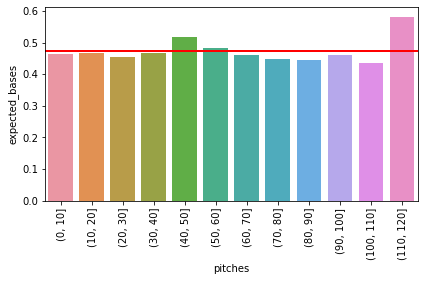

Average pitch_velocity 88.035
       pitches  pitch_velocity  count
0      (0, 10]       88.798940  81354
1     (10, 20]       88.443695  58236
2     (20, 30]       87.986452  33067
3     (30, 40]       87.519400  23402
4     (40, 50]       87.236392  19768
5     (50, 60]       87.208709  17613
6     (60, 70]       87.028123  15610
7     (70, 80]       87.035720  12962
8     (80, 90]       87.130836   9210
9    (90, 100]       87.058981   4476
10  (100, 110]       87.627966   1180
11  (110, 120]       87.671642    134


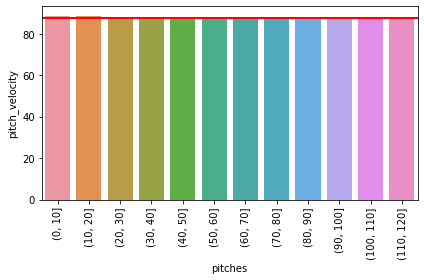

In [12]:
pitcher_fatigue = df.iloc[:,1:]
variables = ['expected_bases','pitch_velocity']    

for variable in variables:
    pitcher_fatigue1 = pitcher_fatigue[['pitches',variable]]
    bin_range = [0,10,20,30,40,50,60,70,80,90,100,110,120]
    pitcher_fatigue1['groups']=pd.cut(pitcher_fatigue1['pitches'],bin_range)
    print('Average',str(variable),round(pitcher_fatigue1[variable].mean(),3))
    pitcher_fatigue1 = pitcher_fatigue1.groupby(['groups'])[variable].agg(['mean','count']).reset_index()
    pitcher_fatigue1 = pitcher_fatigue1.loc[pitcher_fatigue1['count']>100]
    pitcher_fatigue1.columns = ['pitches',variable,'count']
    sns.barplot(x='pitches', y=variable, data=pitcher_fatigue1)
    plt.axhline(pitcher_fatigue1[variable].mean(), color="red",lw=2)
    plt.xticks(rotation=90)
    plt.tight_layout()
    print(pitcher_fatigue1)
    plt.show()
    

### Measuring Pitch Count and Pitch Velocity against Expected Bases
Here I look at how a pitchers expected bases given up compare with the pitch count and the pitchers pace. <br><br>
Firstly, the histogram for pitch count is as expected. When the pitch count is in the batters favour, expected bases are higher, and visa versa. <br>
But there is space for some efficiency gains in batting. For example, at a pitch count of 3-1, a batter can get a walk if he gets a ball in one of the next three balls. A batters expected bases at a 3-1 count is 0.719, but when choosing to play safe and avoid attmepting to hit a players expected bases go up to 0.752. Obviously, this strategy has to be limited due to pitchers becoming aware of the strategy. <br><br>
In terms of pitch velocity, when pitching 97mph and faster the efficiency of a pitcher start to improves rapidly when measured against expected bases. <br><br>
Note: I have taken out data where there was not a big enough sample size, this is why the average expected bases is different.



Average expected bases: 0.471


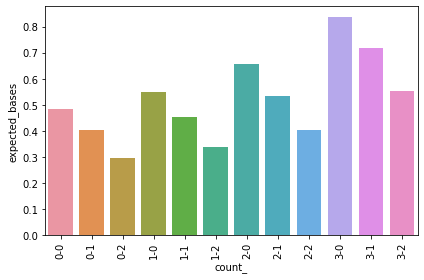

Average expected bases: 0.466


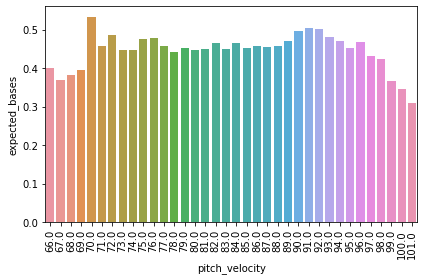

In [13]:
variables = ['count_','pitch_velocity']
for variable in variables:
    analysis = df.drop_duplicates(subset=[variable,'at_bat_id'],keep='last')
    analysis = analysis[[variable,'pitch_result','expected_bases']]
    analysis = analysis.drop('pitch_result', 1).dropna()
    print('Average expected bases:',round(analysis['expected_bases'].mean(),3))
    analysis = analysis.groupby([variable])['expected_bases'].agg(['mean','count']).reset_index()

    analysis.columns = [variable,'expected_bases','count']
    analysis = analysis.loc[analysis['count']>50]

    sns.barplot(x=variable, y="expected_bases", data=analysis)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Example of a small inefficiency

In [14]:
pitch_count_ = '3-1'
analysis = df.drop_duplicates(subset=['count_','at_bat_id'],keep='last')
analysis = analysis[['count_','pitch_result','expected_bases']]
analysis = analysis.drop('pitch_result', 1).dropna()
analysis = analysis.groupby(['count_'])['expected_bases'].agg(['mean','count']).reset_index()
league_avg = round(float(analysis.loc[analysis['count_']== pitch_count_]['mean']),3)

non_ball_rate = 1-df.loc[(df['pitch_result']=='ball') | (df['pitch_result']=='hit by pitch')].shape[0]/df.shape[0]
walk = round(1-(non_ball_rate**3),3)
print('When pitch count is',pitch_count_,'expected bases are',league_avg,'\nWhen leaving ball expected bases are',walk)

When pitch count is 3-1 expected bases are 0.719 
When leaving ball expected bases are 0.752


### Measuring pitch variety strategy
Here I look at how the success of pitchers with more pitch types compare to those with less. <br><br>
Pitchers who throw five different pitches regulary (each pitch more than 15% of pitches) don't seem to be too successful. The data shows that it is best to throw between 2-3 pitch types and throw them regulary. <br>


Number of pitch types above: 0.15 Average expected bases: 0.483


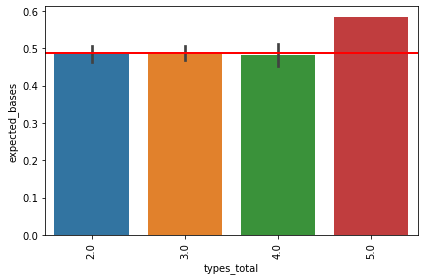

Number of pitch types above: 0.25 Average expected bases: 0.483


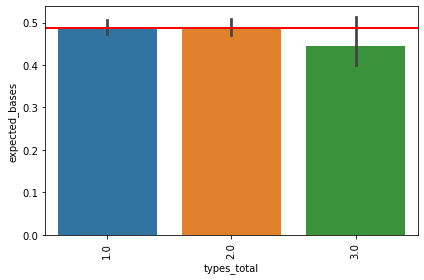

Number of pitch types above: 0.33 Average expected bases: 0.483


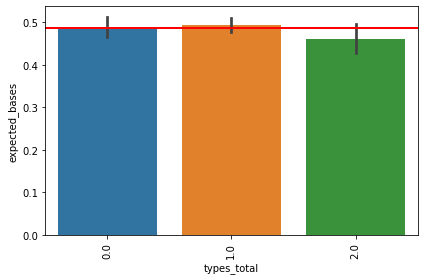

In [15]:
pitchers = df1
pitchers['expected_bases'] = pitchers['pitch_result'].apply(lambda x: 1 if x.lower() in not_out else 0
                   )+pitchers['pitch_result'].apply(lambda x: 1 if 'double' in x.lower() else 0
                   )+pitchers['pitch_result'].apply(lambda x: 1 if 'triple' in x.lower() else 0
                 )*2+pitchers['pitch_result'].apply(lambda x: 1 if 'home run' in x.lower() else 0)*3
pitchers_agg = pitchers.groupby(['pitcher','pitching_team'])['expected_bases'].agg(['mean','count']).reset_index()
pitchers_agg = pitchers_agg.loc[pitchers_agg['count']>=100].sort_values('mean',ascending=False)
pitchers_agg.columns = ['pitcher','pitching_team','expected_bases','count']
pitchers_agg = pitchers_agg.sort_values('expected_bases',ascending=True)

pitch_types = pitcher_starters.loc[pitcher_starters['starter']==1][['pitcher','pitch_type']]
pitch_types = pd.get_dummies(pitch_types, columns=['pitch_type'])
cols = ['pitch_type_Changeup', 'pitch_type_Curve',
       'pitch_type_Cutter', 'pitch_type_Four-seam FB',
       'pitch_type_Knuckle Curve', 'pitch_type_Sinker', 'pitch_type_Slider',
       'pitch_type_Slow Curve', 'pitch_type_Splitter',
       'pitch_type_Two-seam FB']
pitch_types = pitch_types.groupby(['pitcher'])[cols].agg(['sum']).reset_index()
pitch_types.columns = list(['pitcher']+cols)
pitch_types['total_pitches'] = pitch_types.apply(lambda x: sum(x[cols]),axis=1)
pitch_types[cols] = pitch_types.apply(lambda x: x[cols]/x['total_pitches'],axis=1)

pitch_freqs = [.15,.25,.33]
for pitch_freq in pitch_freqs:
    pitch_types1 = pitch_types
    pitch_types1['types_total'] = pitch_types1.apply(lambda x: sum(x[cols]>=pitch_freq),axis=1)
    pitch_types1 = pitch_types1[['pitcher','total_pitches','types_total']]

    pitch_types1 = pd.merge(pitch_types1,pitchers_agg[['pitcher','expected_bases']],left_on=['pitcher']
                                              ,right_on=['pitcher'],how='outer').dropna()

    print('Number of pitch types above:',pitch_freq,'Average expected bases:',round(pitch_types1['expected_bases'].mean(),3))
    pitch_types1 = pitch_types1.loc[pitch_types1['total_pitches']>300]
    sns.barplot(x='types_total', y="expected_bases", data=pitch_types1)
    plt.axhline(pitch_types1['expected_bases'].mean(), color="red",lw=2)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

The data below backs this theory up.<br>
The first part, shows the success for all pitch types for pitchers that choose to pitch three different pitches all over 25%. Alongside this is average expected bases for all these pitchers.<br>
The second part, shows the lack of success for all pitch types for pitchers that choose to pitch five different pitches all over 15%. Alongside this is average expected bases for all these pitchers. <br>

In [12]:
pitches = ['pitch_type_Changeup', 'pitch_type_Curve',
       'pitch_type_Cutter', 'pitch_type_Four-seam FB',
       'pitch_type_Knuckle Curve', 'pitch_type_Sinker', 'pitch_type_Slider',
       'pitch_type_Slow Curve', 'pitch_type_Splitter',
       'pitch_type_Two-seam FB']
sum_ = 0
count_ = 0
for pitch in pitches:
    
    pitch_types1 = pitch_types
    pitch_types1['types_total'] = pitch_types1.apply(lambda x: sum(x[cols]>=.25),axis=1)
    bad_pitch = pitch_types1.loc[(pitch_types1[pitch]>0.25) & (pitch_types1['types_total']==3)]['pitcher']
    pitch = pitch.replace('pitch_type_','')
    exp = df.loc[(df['pitch_type']==pitch) & (df['pitcher'].isin(bad_pitch))]['expected_bases']
    if exp.count()>100:
        print(pitch,',',round(exp.mean(),3),',',exp.count())
        sum_ = exp.sum() +sum_
        count_ = exp.count() + count_
print('League average:',round(df['expected_bases'].mean(),3))
print('Average of players in this data:',round(sum_/count_,3))
print()
sum_ = 0
count_ = 0
for pitch in pitches:
    pitch_types1 = pitch_types
    pitch_types1['types_total'] = pitch_types1.apply(lambda x: sum(x[cols]>=.15),axis=1)
    bad_pitch = pitch_types1.loc[(pitch_types1[pitch]>0.15) & (pitch_types1['types_total']==5)]['pitcher']
    pitch = pitch.replace('pitch_type_','')
    exp = df.loc[(df['pitch_type']==pitch) & (df['pitcher'].isin(bad_pitch))]['expected_bases']
    if exp.count()>100:
        print(pitch,',',round(exp.mean(),3),',',exp.count())
        sum_ = exp.sum() +sum_
        count_ = exp.count() + count_
print('League average:',round(df['expected_bases'].mean(),3))
print('Average of players in this data:',round(sum_/count_,3))


Changeup , 0.404 , 1375
Curve , 0.376 , 773
Cutter , 0.473 , 835
Four-seam FB , 0.447 , 2164
Knuckle Curve , 0.422 , 405
Sinker , 0.428 , 1501
Slider , 0.356 , 960
League average: 0.467
Average of players in this data: 0.42

Changeup , 0.553 , 237
Curve , 0.568 , 301
Cutter , 0.63 , 208
Four-seam FB , 0.524 , 311
Sinker , 0.57 , 291
Slider , 0.443 , 194
League average: 0.467
Average of players in this data: 0.55


### Pitchers and Batters expected bases for the 2020 season (over 100 plate visits)

In [13]:
pitchers_agg.head(10)

,pitcher,pitching_team,expected_bases,count
461,Liam Hendriks,OAK,0.267241,116
217,Devin Williams,MIL,0.270000,100
9,Aaron Slegers,TB,0.300000,120
307,Jake Diekman,OAK,0.310680,103
77,Brad Keller,KC,0.316279,215
106,Brusdar Graterol,LAD,0.318182,110
222,Dinelson Lamet,SD,0.333333,267
289,Ian Anderson,ATL,0.334884,215
538,Nick Anderson,TB,0.336538,104
484,Mark Melancon,ATL,0.339130,115


In [14]:
batters = df1
batters['expected_bases'] = batters['pitch_result'].apply(lambda x: 1 if x.lower() in not_out else 0
                   )+batters['pitch_result'].apply(lambda x: 1 if 'double' in x.lower() else 0
                   )+batters['pitch_result'].apply(lambda x: 1 if 'triple' in x.lower() else 0
                 )*2+batters['pitch_result'].apply(lambda x: 1 if 'home run' in x.lower() else 0)*3
batters_agg = batters.groupby(['batter','batting_team'])['expected_bases'].agg(['mean','count']).reset_index()
batters_agg = batters_agg.loc[batters_agg['count']>=100].sort_values('mean',ascending=False)
batters_agg.loc[batters_agg['batting_team']=='SEA']
batters_agg.head(10)

,batter,batting_team,mean,count
339,Juan Soto,WSH,0.763158,190
490,Randy Arozarena,TB,0.748201,139
217,Giancarlo Stanton,NYY,0.693548,124
209,Freddie Freeman,ATL,0.687296,307
325,Jose Ramirez,CLE,0.676806,263
264,Jared Walsh,LAA,0.675926,108
440,Mike Trout,LAA,0.663866,238
520,Salvador Perez,KC,0.662420,157
73,Brandon Belt,SF,0.657303,178
398,Marcell Ozuna,ATL,0.653125,320
